In [27]:
import csv
import re
import json
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import maxabs_scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in train and test sets
train_tweets = []
train_scores = []
with open("training_data/training.1600000.processed.noemoticon.csv", "r") as train_file:
    trainreader = csv.reader(train_file)
    try:
        for row in trainreader:
            score = int(row[0])/4
            if score != 0.5:
                train_tweets.append(row[5])
                train_scores.append(score)
    except UnicodeDecodeError:
        print(row)
        
test_tweets = []
test_scores = []
with open("training_data/testdata.manual.2009.06.14.csv", "r") as test_file:
    testreader = csv.reader(test_file)
    try:
        for row in testreader:
            score = int(row[0])/4
            if score != 0.5:
                test_tweets.append(row[5])
                test_scores.append(score)
    except UnicodeDecodeError:
        print(row)

In [3]:
# Preprocess data
def preprocess(tweets):
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_USER = re.compile("@.+?\s")
    tweets = [REPLACE_NO_SPACE.sub("", line.lower()) for line in tweets]
    tweets = [REPLACE_USER.sub("@_ ", line.lower()) for line in tweets]
    return tweets

train_tweets = preprocess(train_tweets)
test_tweets = preprocess(test_tweets)

In [4]:
# Generate features from raw text
cv = CountVectorizer(binary=True)
cv.fit(train_tweets)
X = cv.transform(train_tweets)
X_test = cv.transform(test_tweets)
# Normalize data
X_scale = maxabs_scale(X)
X_test_scale = maxabs_scale(X_test)

In [5]:
# Get training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, train_scores, train_size = 0.75
)

In [6]:
# Find hyperparameters
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c, solver="saga")
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.78726
Accuracy for C=0.05: 0.7949575
Accuracy for C=0.25: 0.7980075
Accuracy for C=0.5: 0.7979125
Accuracy for C=1: 0.7969875


In [7]:
# Train model with all data
final_model = LogisticRegression(C=0.25, solver="saga")
final_model.fit(X, train_scores)
print ("Final Accuracy: %s" 
       % accuracy_score(test_scores, final_model.predict(X_test)))

Final Accuracy: 0.8105849582172702


In [8]:
# Load movie data
movie_tweets = json.load(open("movie_data/movie_tweets_premiere.json", "r"))

In [13]:
movie_scores = {}

In [14]:
# Get average sentiment for each movie
for movie, data in sorted(movie_tweets.items(), key=lambda x:x[0]):
    tweets = [tweet["text"] for tweet in data]
    feats = cv.transform(preprocess(tweets))
    preds = final_model.predict_proba(feats)
    movie_scores[movie] = [np.mean(preds, axis=0)[1], None]
    print(movie, np.mean(preds, axis=0)[1])

Ad Astra 0.6350407334351073
Angel Has Fallen 0.5502647775559566
Avengers: Endgame 0.6742976488003304
Birds of Prey 0.6721081593465642
Coffee & Kareem 0.7844134343482377
Detective Pikachu 0.7820683379918892
Frozen II 0.5653785244302139
Gemini Man 0.6716053384697311
Hobbs & Shaw 0.7245403209725297
Jojo Rabbit 0.5531634847828482
Klaus 0.7145197564030435
Knives Out 0.6787035967582224
Marriage Story 0.6840877335635805
Queen & Slim 0.6869901310140873
Spies in Disguise 0.6505293214440556
The Irishman 0.7091920132385156
The Two Popes 0.807914722859127
Trolls World Tour 0.7871119248161093
Uncut Gems 0.7084006787647441
Vivarium 0.7084784638225646


In [23]:
with open("movie_data/movie_info.csv", "r") as review_file:
    review_reader = csv.reader(review_file)
    next(review_reader)
    for row in review_reader:
        movie_scores[row[0]][1] = int(row[5])/100

Correlation =  -0.3403878378361949
p-value     =  0.1419646964277822


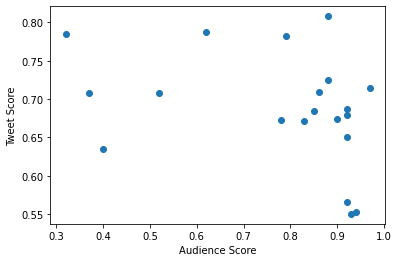

In [33]:
x = [score[1] for score in movie_scores.values()]
y = [score[0] for score in movie_scores.values()]
corr, p = pearsonr(x, y)
print("Correlation = ", corr)
print("p-value     = ", p)
plt.scatter(x, y)
plt.xlabel("Audience Score")
plt.ylabel("Tweet Score")
plt.show()